# Data wrangling scripts

## Imports and function definitions

In [2]:
import os
import rasterio as rio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil
import utils
import tifffile as tiff

%load_ext autoreload
%autoreload 2

def rescale_and_save(in_fn):
    fn = in_fn.replace("10cm", "20cm")
    out_fn_rgb = fn.replace(".tif", "_rgb.tif")
    out_fn_nir = fn.replace(".tif", "_nir.tif")
    
    if not os.path.exists(fn.split("/Ortho")[0]):
        os.makedirs(os.path.join(fn.split("/Ortho")[0], "Ortho"))
        
    r =  rio.open(in_fn)
    downscale_factor = 0.5
    r_arr = r.read(
        out_shape=(
                r.count,
                int(r.height * downscale_factor),
                int(r.width * downscale_factor)
            ),
            resampling=Resampling.bilinear
    )


    type(r_arr)
    # r_arr = np.moveaxis(r_arr, 0, -1)

    for i in range(4):
        max = r_arr[i].max()
        # max = 2**16
        r_arr[i] = (r_arr[i] / max) * 255
    # r_arr = np.flip(r_arr[0:3, ...], axis=0)
    R = r_arr[2].copy()
    G = r_arr[1]
    B = r_arr[0].copy()

    r_arr[0] = R
    r_arr[2] = B

    # scale image transform
    transform = r.transform * r.transform.scale(
        (r.width / r_arr.shape[-1]),
        (r.height / r_arr.shape[-2])
    )

    rgb_profile = r.profile.copy()
    rgb_profile.update(
        driver="GTiff",
        height=r_arr.shape[1],
        width=r_arr.shape[2],
        dtype=r_arr.dtype,
        count=3,
        transform=transform
    )

    nir_profile = rgb_profile.copy()
    nir_profile.update(
        count=1
    )

    new_rgb = rio.open(
        out_fn_rgb,
        'w',
        **rgb_profile
    )
    new_nir = rio.open(
        out_fn_nir,
        'w',
        **nir_profile
    )
    new_rgb.write(r_arr[0:3])
    new_nir.write(np.expand_dims(r_arr[3], 0))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Downsample 10 cm files to 20 cm with radiometric rescaling and save

In [ ]:
RESCALE = False

if RESCALE:
    dirs = glob.glob("data/*10cm")
    for dir in dirs[1:]:
        fns = glob.glob(os.path.join(dir, "Ortho/*.tif"))
        for fn in fns:
            rescale_and_save(fn)

## Reorganize files

Desired file structure:
- {location}
    - {resolution}
        - Ortho
            - {tilename}
                - rgb
                    - {tilename}_rgb.tif
                - cir
                    - {tilename}_cir.tif
                - labels
                    - {tilename}_labels.tif

In [ ]:
REORGANIZE = False

if REORGANIZE:

    DATA_DIR = "data"
    IM_DIRS = ["rgb", "nir", "labels"]
    dirs = glob.glob(f"data/WA_Shishmaref_01_20210628/")
    tilenames = []

    for dir in dirs:
        dir = os.path.join(dir, "20cm/Ortho")
        files = glob.glob(f"{dir}/*.tif")
        
        for file in files:
            # Get the tilename
            tilename = os.path.basename(file).rsplit("_", 1)[0]
            tile_dir = os.path.join(dir, tilename)

            if not os.path.exists(tile_dir):
                # Create the tile directory and subdirectories
                # shutil.rmtree(tile_dir)
                os.mkdir(tile_dir)
                for im_dir in IM_DIRS:
                    os.mkdir(os.path.join(tile_dir, im_dir))
            
            for im_dir in IM_DIRS:
                if file.endswith(f"{im_dir}.tif"):
                    shutil.move(file, os.path.join(tile_dir, im_dir))
        

## Sandbox for aggregating and patchifying


In [8]:
data_dir = "data/WA_Kotzebue_01_20210625/20cm/Ortho"
dirs = glob.glob(f"{data_dir}/*")
IM_DIRS = ["rgb", "nir", "labels"]
rgb_fns, nir_fns, label_fns = [], [], []

for dir in dirs:
    rgb = glob.glob(f"{dir}/rgb/*.tif")[0]
    nir = glob.glob(f"{dir}/nir/*.tif")[0]
    labels = glob.glob(f"{dir}/labels/*.tif")[0]
    rgb_fns.append(rgb)
    nir_fns.append(nir)
    label_fns.append(labels)

In [ ]:
for f in rgb_fns:
    im = tiff.imread(f)
    print(im.shape)

In [45]:
k = 0
rgb_im = tiff.imread(rgb_fns[k])
# nir_im = np.expand_dims(tiff.imread(nir_fns[k]), -1)
r = np.dstack((rgb_im, nir_im))

In [ ]:
# Allow division by zero
np.seterr(divide="ignore", invalid="ignore")
r = r.astype(np.float64)
ndvi = (r[..., -1] - r[..., 0]) / (r[..., -1] + r[..., 0])
ndvi[np.isnan(ndvi)] = -1
ndvi = (((ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())) * 255).astype(np.uint16)
ndvi


In [48]:
labels = tiff.imread(label_fns[k])

In [3]:
def concat_train_test(X_train, y_train, X_test, y_test, X_train_add, y_train_add, X_test_add, y_test_add):
    X_train = np.concatenate((X_train, X_train_add), axis=0)
    y_train = np.concatenate((y_train, y_train_add), axis=0)
    X_test = np.concatenate((X_test, X_test_add), axis=0)
    y_test = np.concatenate((y_test, y_test_add), axis=0)
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = utils.prep_data(
    "data/WA_Kivalina_01_20219703/20cm/Ortho",
    include_nir=True,
    add_ndvi=True,
    select_labels=[1, 2],
    squash=True,
    img_size_override=2500,
)

# X_train_add, y_train_add, X_test_add, y_test_add = utils.prep_data(
#     "data/WA_Kotzebue_01_20210625/20cm/Ortho",
#     include_nir=False,
#     add_ndvi=False,
#     squash=True,
#     img_size_override=2500,
# )

# X_train, y_train, X_test, y_test = concat_train_test(
#     X_train, y_train, X_test, y_test, X_train_add, y_train_add, X_test_add, y_test_add
# )

# X_train_add, y_train_add, X_test_add, y_test_add = utils.prep_data(
#     "data/WA_Shishmaref_01_20210628/20cm/Ortho",
#     include_nir=False,
#     add_ndvi=False,
#     squash=True,
#     img_size_override=2500,
# )

# X_train, y_train, X_test, y_test = concat_train_test(
#     X_train, y_train, X_test, y_test, X_train_add, y_train_add, X_test_add, y_test_add
# )

print("\nFinal concatenated sizes:\n")
print("-------------------------\n")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Removing irregular-shaped images...
-------------------------------------
bad ims length: 2
m: 16
Cull rows: -32
Shape before: (368, 512, 512, 5)
Shape after: (336, 512, 512, 5)

Removing images with nodata values...
-------------------------------------
Training set size with nodata: 336

Patched data sizes w/o nodata:
data_train: (178, 512, 512, 5)
data_label: (178, 512, 512, 1)

Removing images with no positive labels...
-------------------------------------
Number of no label patches before removal: 147
Keep n labels: 74
# of keep idx: 74
Number of no label patches after removal: 73

Dataset sizes:
    X_train: (70, 512, 512, 5)
    y_train: (70, 512, 512, 1)
    X_test: (35, 512, 512, 5)
    y_test: (35, 512, 512, 1)

Final concatenated sizes:

-------------------------

X_train: (70, 512, 512, 5)
y_train: (70, 512, 512, 1)
X_test: (35, 512, 512, 5)
y_test: (35, 512, 512, 1)


In [21]:
(X_train.nbytes / 1024 / 1024.2) - (X_train.astype(np.float1).nbytes / 1024 / 1024.2)

349.9316539738332

In [23]:
y_train.nbytes / 1024 / 1024.2

139.9726615895333

1. List of whether or not patches have labels
2. Change the value of half of the patches that don't have labels (true -> false)
3. Remove the remaining true values

In [76]:
# Generate list of whether or not patches have labels
no_label_patches = []
for patch in y_train:
    no_label_patches.append(np.all(patch == 0))

no_label_patches = np.asarray(no_label_patches) # All true have no labels

# Change the value of half of the patches that don't have labels (true -> false)
no_label_patches_idx = np.where(no_label_patches)[0] # Don't have labels
print(no_label_patches_idx)
print("Number of no label patches before removal:", no_label_patches_idx.shape[0])
keep_n = round(no_label_patches_idx.shape[0] * 0.5) # 50% of count of no-label patches
print("Keep n labels:", keep_n)
keep_idx = np.sort(np.random.choice(no_label_patches_idx, keep_n, replace=False))
print("# of keep idx:", len(keep_idx))
print("keep IDs:", keep_idx)

no_label_patches[keep_idx] = False
no_label_patches_idx = np.where(no_label_patches)[0]
print("Number of no label patches after removal:", no_label_patches_idx.shape[0])

y_train_new = y_train.copy()
y_train_new = y_train_new[~no_label_patches]

# no_label_patches
# no_label_patches_idx

# no_label_patches = np.asarray(no_label_patches))[0]
# print("number of no_label_patches:", no_label_patches.shape[0])
# n = round(no_label_patches.shape[0]*0.75)
# print(f"Removing {n} patches...")
# cull_labels_idx = np.random.choice(no_label_patches, n)
# print(cull_labels_idx)
# no_label_patches[cull_labels_idx] = False
# print("y_train before culling:", y_train.shape[0])
# print("y_train after culling:", y_train[~cull_labels_idx].shape[0])

[  1   2   3   4   5   6   7  10  11  12  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  31  34  35  36  37  38  40  41  45  51  52  53
  54  55  57  59  60  63  64  65  66  67  68  70  72  73  75  76  77  79
  80  82  85  87  88  89  91  92  94  95  96  98  99 100 101 102 103 104
 108 110 111 112 117 118]
Number of no label patches before removal: 78
Keep n labels: 39
# of keep idx: 39
keep IDs: [  1   3   6  10  11  12  16  17  21  24  26  27  28  40  41  45  52  53
  54  55  59  60  63  64  66  68  73  75  82  92  95  96 100 101 103 104
 111 112 117]
Number of no label patches after removal: 39


In [77]:
print(y_train.shape)
print(y_train_new.shape)

(119, 512, 512, 1)
(80, 512, 512, 1)


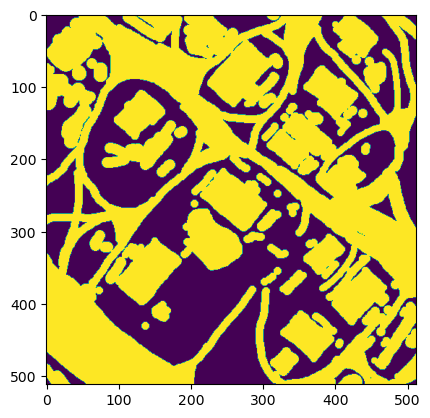

In [60]:
plt.imshow(y_train[8])

xmin: 0.12156862745098039


Text(0.5, 1.0, 'tile 108')

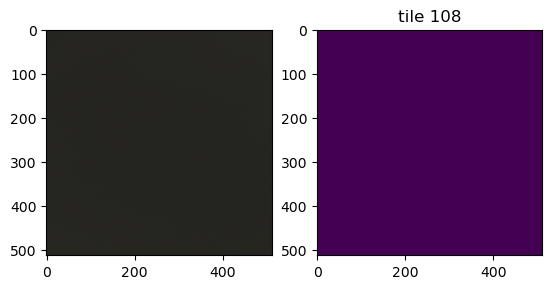

In [30]:
_, (ax0, ax1) = plt.subplots(1, 2)
k = np.random.randint(0, X_train.shape[0] - 1)
# k = 86
x = X_train[k]
y = y_train[k]
print("xmin:", x.min())
idx = x[x==0].astype(np.uint8)
x[idx] = np.nan
y[idx] = np.nan
ax0.imshow(x)
ax1.imshow(y)
plt.title(f"tile {k}")

In [103]:
arr = np.array([2, 5, 6, 7, 4, 3, 0, 0, 1, 2, 3])
labs = [2, 3]
arr[~np.isin(arr, labs)] = 0
arr

array([2, 0, 0, 0, 0, 3, 0, 0, 0, 2, 3])